<a href="https://colab.research.google.com/github/FlyAIBox/langchain-academy/blob/fly101/module-2/chatbot-external-memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 聊天机器人：消息摘要与外部数据库内存

## 课程回顾

在前面的课程中，我们已经学习了如何自定义图状态模式和状态缩减器。

我们也展示了一些修剪或过滤图中消息的技巧。

我们使用这些概念构建了一个具有内存的聊天机器人，它能够生成对话的运行摘要。

## 学习目标

但是，如果我们希望聊天机器人拥有可以无限期持久化的内存呢？

现在，我们将介绍一些更高级的检查点器，它们支持外部数据库。

在这里，我们将展示如何使用 [SQLite作为检查点器](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer)，但其他检查点器（如 [Postgres](https://langchain-ai.github.io/langgraph/how-tos/persistence_postgres/)）也是可用的！

## 核心概念

### 什么是检查点器（Checkpointer）？
检查点器是LangGraph中用于保存和恢复图执行状态的组件。它允许：
- **状态持久化**：将对话状态保存到外部存储
- **会话恢复**：在应用重启后恢复之前的对话
- **多线程支持**：支持多个并发对话会话
- **历史追踪**：记录完整的执行历史

### 为什么需要外部数据库？
- **内存限制**：Python进程重启后，内存中的状态会丢失
- **可扩展性**：支持多个用户同时使用
- **可靠性**：数据持久化，不会因系统故障丢失
- **生产环境**：满足生产环境的数据存储需求

In [ ]:
# 安装必要的依赖包
# 这个命令会安装LangGraph的SQLite检查点器和其他核心依赖
%%capture --no-stderr
# %pip install --quiet -U langgraph-checkpoint-sqlite langchain_core langgraph langchain_openai
%pip install --quiet langchain_openai==0.3.32 langchain_core==0.3.75 langgraph==0.6.7 langgraph-checkpoint-sqlite==2.0.11
# 依赖包说明：
# - langgraph-checkpoint-sqlite: SQLite检查点器，用于持久化状态
# - langchain_core: LangChain核心功能
# - langgraph: LangGraph图执行框架
# - langchain_openai: OpenAI模型集成

In [2]:
# 环境变量配置
# 设置OpenAI API密钥，这是使用OpenAI模型所必需的
import os, getpass

def _set_env(var: str):
    """
    安全地设置环境变量
    如果环境变量不存在，会提示用户输入
    """
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# 设置OpenAI API密钥
# 您需要从 https://platform.openai.com/api-keys 获取API密钥
_set_env("OPENAI_API_KEY")
# 设置 OpenAI API代理地址 (例如：https://api.apiyi.com/v1）
_set_env("OPENAI_BASE_URL")

OPENAI_API_KEY: ··········
OPENAI_BASE_URL: ··········


## SQLite 数据库介绍

这里我们使用 [SqliteSaver检查点器](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer) 作为起点。

SQLite是一个[小巧、快速、高度流行](https://x.com/karpathy/status/1819490455664685297)的SQL数据库。

### SQLite的优势
- **轻量级**：无需单独的数据库服务器
- **零配置**：开箱即用
- **跨平台**：支持所有主流操作系统
- **ACID兼容**：支持事务处理
- **嵌入式**：可以直接嵌入到应用程序中

如果我们提供 `":memory:"` 参数，它会创建一个内存中的SQLite数据库。

In [3]:
# 创建SQLite数据库连接
import sqlite3

# 创建内存数据库连接
# ":memory:" 表示创建一个临时的内存数据库
# check_same_thread=False 允许多线程访问（LangGraph需要）
conn = sqlite3.connect(":memory:", check_same_thread=False)

print("✅ 已创建内存SQLite数据库连接")
print("📝 注意：内存数据库在程序结束后会丢失数据")

✅ 已创建内存SQLite数据库连接
📝 注意：内存数据库在程序结束后会丢失数据


但是，如果我们提供一个数据库路径，它就会为我们创建一个持久化的数据库文件！

In [4]:
# 创建持久化数据库
# 首先创建目录并下载示例数据库文件（如果不存在）
!mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db

# 设置数据库文件路径
db_path = "state_db/example.db"

# 连接到持久化数据库文件
# 这个数据库文件会保存在磁盘上，程序重启后数据不会丢失
conn = sqlite3.connect(db_path, check_same_thread=False)

print("✅ 已连接到持久化SQLite数据库")
print(f"📁 数据库文件位置: {db_path}")
print("💾 数据将持久化保存到磁盘")

--2025-09-11 09:41:25--  https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/langchain-ai/langchain-academy/main/module-2/state_db/example.db [following]
--2025-09-11 09:41:25--  https://raw.githubusercontent.com/langchain-ai/langchain-academy/main/module-2/state_db/example.db
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110592 (108K) [application/octet-stream]
Saving to: ‘state_db/example.db’

example.db          100%[===================>] 108.00K  --.-KB/s    in 0.1s    

2025-09-11 09:41:26 (921 KB/s) - ‘

In [5]:
# 创建SQLite检查点器
# 这是LangGraph中用于持久化状态的组件
from langgraph.checkpoint.sqlite import SqliteSaver

# 使用SQLite连接创建检查点器
# 这个检查点器将负责保存和恢复图的状态
memory = SqliteSaver(conn)

print("✅ 已创建SQLite检查点器")
print("🔧 检查点器将管理对话状态的持久化")

✅ 已创建SQLite检查点器
🔧 检查点器将管理对话状态的持久化


现在让我们重新定义我们的聊天机器人。

## 聊天机器人架构设计

我们将构建一个具有以下功能的智能聊天机器人：

### 核心功能
1. **对话管理**：处理用户输入并生成回复
2. **消息摘要**：当对话过长时自动生成摘要
3. **状态持久化**：使用SQLite保存对话历史
4. **智能路由**：根据对话长度决定是否进行摘要

### 状态设计
- **messages**：存储对话消息列表
- **summary**：存储对话摘要
- **自动摘要触发**：当消息数量超过6条时触发摘要

In [7]:
# 导入必要的库
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langgraph.graph import END
from langgraph.graph import MessagesState

# 初始化OpenAI模型
# 使用GPT-4o模型，temperature=0确保输出稳定一致
model = ChatOpenAI(model="gpt-4o", temperature=0)

# 定义状态类
# 继承MessagesState，添加summary字段用于存储对话摘要
class State(MessagesState):
    """聊天机器人状态类"""
    summary: str  # 存储对话摘要

def call_model(state: State):
    """
    调用AI模型生成回复

    Args:
        state: 当前对话状态

    Returns:
        dict: 包含AI回复的状态更新
    """
    # 获取现有摘要（如果存在）
    summary = state.get("summary", "")

    # 如果存在摘要，将其添加到系统消息中
    if summary:
        # 创建包含摘要的系统消息
        system_message = f"此前对话的摘要：{summary}"
        # 将系统消息添加到消息列表开头
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        # 如果没有摘要，直接使用原始消息
        messages = state["messages"]

    # 调用AI模型生成回复
    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State):
    """
    对对话进行摘要处理

    当对话消息过多时，生成摘要并删除旧消息

    Args:
        state: 当前对话状态

    Returns:
        dict: 包含新摘要和删除消息的状态更新
    """
    # 获取现有摘要
    summary = state.get("summary", "")

    if summary:
      # 如果摘要已存在，则扩展现有摘要
      summary_message = (
          f"目前为止的对话摘要：{summary}\n\n"
          "请结合上方的新消息，扩展现有摘要："
      )

    else:
        # 如果没有现有摘要，则创建新摘要
        summary_message = "请对上方的对话创建摘要："

    # 将摘要提示添加到消息历史中
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # 删除除最近2条消息外的所有消息
    # 使用RemoveMessage来标记要删除的消息
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]

    return {"summary": response.content, "messages": delete_messages}

def should_continue(state: State):
    """
    决定下一步执行哪个节点

    根据对话长度决定是继续对话还是进行摘要

    Args:
        state: 当前对话状态

    Returns:
        str: 下一个要执行的节点名称或END
    """
    messages = state["messages"]

    # 如果消息超过6条，则进行摘要
    if len(messages) > 6:
        return "summarize_conversation"

    # 否则结束对话
    return END

现在，我们使用SQLite检查点器重新编译图。

## 图构建过程

我们将创建一个包含以下组件的LangGraph：

### 节点（Nodes）
1. **conversation**：处理用户输入并生成AI回复
2. **summarize_conversation**：当对话过长时生成摘要

### 边（Edges）
1. **START → conversation**：从开始节点到对话节点
2. **conversation → should_continue**：条件边，决定下一步
3. **summarize_conversation → END**：摘要完成后结束

### 检查点器集成
- 使用SQLite检查点器实现状态持久化
- 支持多线程并发访问
- 自动保存和恢复对话状态

🎯 聊天机器人图结构已构建完成
📊 下图显示了节点和边的连接关系


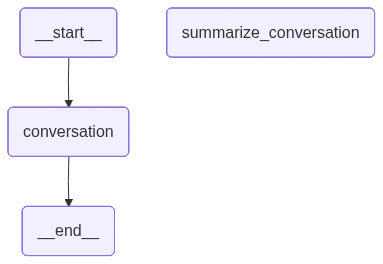

In [9]:
# 构建LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START

# 创建状态图
workflow = StateGraph(State)

# 添加节点
# conversation节点：处理用户输入并生成AI回复
workflow.add_node("conversation", call_model)
# summarize_conversation节点：生成对话摘要
workflow.add_node("summarize_conversation", summarize_conversation)

# 添加边
# 从开始节点到对话节点
workflow.add_edge(START, "conversation")
# 条件边：根据对话长度决定下一步
workflow.add_conditional_edges("conversation", should_continue)
# 摘要完成后结束
workflow.add_edge("summarize_conversation", END)

# 编译图并集成SQLite检查点器
# checkpointer参数启用状态持久化
graph = workflow.compile(checkpointer=memory)

# 显示图的Mermaid可视化
print("🎯 聊天机器人图结构已构建完成")
print("📊 下图显示了节点和边的连接关系")
display(Image(graph.get_graph().draw_mermaid_png()))

现在，我们可以多次调用图来测试聊天机器人的功能。

## 测试聊天机器人

我们将进行以下测试：

### 测试场景
1. **自我介绍**：用户介绍自己的名字
2. **记忆测试**：询问用户名字，测试AI的记忆能力
3. **兴趣分享**：用户分享兴趣爱好
4. **状态持久化**：验证状态是否正确保存到数据库

### 配置说明
- **thread_id**：用于标识不同的对话会话
- **config**：包含线程ID的配置对象
- **持久化**：每次调用都会自动保存状态到SQLite数据库

In [11]:
# 创建对话线程配置
# thread_id用于标识不同的对话会话，相同ID的对话会共享状态
config = {"configurable": {"thread_id": "1"}}

print("🚀 开始聊天机器人测试")
print("=" * 50)

# 测试1：用户自我介绍
print("\n📝 测试1：用户自我介绍")
input_message = HumanMessage(content="你好！我是Lance")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

# 测试2：AI记忆测试
print("\n🧠 测试2：AI记忆测试")
input_message = HumanMessage(content="我叫什么名字？")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

# 测试3：用户分享兴趣
print("\n🎯 测试3：用户分享兴趣")
input_message = HumanMessage(content="我喜欢YoYoMA的古典音乐")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

print("\n✅ 聊天机器人测试完成")
print("💾 所有对话状态已保存到SQLite数据库")

🚀 开始聊天机器人测试

📝 测试1：用户自我介绍
================================== Ai Message ==================================

你好，Lance！很高兴再次见到你。你对49人队有什么特别想聊的吗？比如他们的现有阵容、历史故事或者精彩比赛？

🧠 测试2：AI记忆测试
================================== Ai Message ==================================

你叫Lance。有什么特别想聊的话题吗？

🎯 测试3：用户分享兴趣
================================== Ai Message ==================================

Yo-Yo Ma是一位非常杰出的古典大提琴家，他的音乐确实非常动人。他的演奏风格优雅且富有情感，尤其是在巴赫无伴奏大提琴组曲中的表现令人难忘。你有特别喜欢的作品或演奏会吗？

✅ 聊天机器人测试完成
💾 所有对话状态已保存到SQLite数据库


让我们确认状态已正确保存到本地数据库。

## 状态持久化验证

我们将检查以下内容：

### 状态检查项目
1. **消息历史**：验证所有对话消息是否保存
2. **摘要信息**：检查对话摘要是否正确生成
3. **元数据**：查看执行步骤和配置信息
4. **时间戳**：确认状态保存时间

### 状态结构说明
- **values**：包含实际的状态数据（消息和摘要）
- **next**：下一步要执行的节点
- **config**：配置信息，包括线程ID和检查点ID
- **metadata**：执行元数据，包括步骤数和父节点信息

In [12]:
# 获取当前对话状态
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)

print("🔍 检查保存的对话状态")
print("=" * 50)

# 显示状态信息
print(f"📊 状态概览:")
print(f"  - 消息数量: {len(graph_state.values['messages'])}")
print(f"  - 是否有摘要: {'是' if graph_state.values.get('summary') else '否'}")
print(f"  - 执行步骤: {graph_state.metadata.get('step', 'N/A')}")
print(f"  - 创建时间: {graph_state.created_at}")

print(f"\n💬 消息历史:")
for i, msg in enumerate(graph_state.values['messages'], 1):
    msg_type = "👤 用户" if hasattr(msg, 'content') and isinstance(msg, HumanMessage) else "🤖 AI"
    print(f"  {i}. {msg_type}: {msg.content[:50]}{'...' if len(msg.content) > 50 else ''}")

if graph_state.values.get('summary'):
    print(f"\n📝 对话摘要:")
    print(f"  {graph_state.values['summary'][:100]}{'...' if len(graph_state.values['summary']) > 100 else ''}")

print(f"\n✅ 状态持久化验证完成")
print(f"💾 状态已成功保存到SQLite数据库")

🔍 检查保存的对话状态
📊 状态概览:
  - 消息数量: 6
  - 是否有摘要: 是
  - 执行步骤: 37
  - 创建时间: 2025-09-11T09:44:30.183827+00:00

💬 消息历史:
  1. 👤 用户: 你好！我是Lance
  2. 🤖 AI: 你好，Lance！很高兴再次见到你。你对49人队有什么特别想聊的吗？比如他们的现有阵容、历史故事或者...
  3. 👤 用户: 我叫什么名字？
  4. 🤖 AI: 你叫Lance。有什么特别想聊的话题吗？
  5. 👤 用户: 我喜欢YoYoMA的古典音乐
  6. 🤖 AI: Yo-Yo Ma是一位非常杰出的古典大提琴家，他的音乐确实非常动人。他的演奏风格优雅且富有情感，尤其...

📝 对话摘要:
  在最近的对话中，Lance用中文再次介绍了自己，并重申了他对旧金山49人橄榄球队的喜爱。AI助手用中文回应，确认了Lance的名字，并继续表达了对讨论49人队的兴趣，提供了多个话题选择，如球队的现有阵...

✅ 状态持久化验证完成
💾 状态已成功保存到SQLite数据库


### 状态持久化验证

使用SQLite等数据库意味着状态是持久化的！

## 持久化的优势

### 数据持久性
- **程序重启**：即使重启Python内核，数据仍然保存
- **会话恢复**：可以恢复之前的对话状态
- **多实例支持**：多个应用实例可以共享同一数据库

### 实际应用场景
1. **Web应用**：用户关闭浏览器后重新打开，对话继续
2. **API服务**：服务重启后，用户会话不会丢失
3. **多用户系统**：不同用户拥有独立的对话线程
4. **数据分析**：可以分析历史对话数据

## 测试持久化功能

让我们验证状态确实被持久化保存了。即使重新获取状态，数据仍然存在。


In [13]:
# 重新获取状态，验证持久化
# 即使重新创建配置对象，状态仍然可以从数据库恢复
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)

print("🔄 重新获取状态，验证持久化")
print("=" * 50)

# 验证状态是否完整恢复
print(f"📊 状态恢复验证:")
print(f"  - 消息数量: {len(graph_state.values['messages'])}")
print(f"  - 是否有摘要: {'是' if graph_state.values.get('summary') else '否'}")
print(f"  - 状态完整性: {'✅ 完整' if graph_state.values else '❌ 不完整'}")

print(f"\n💾 持久化状态:")
print(f"  - 数据库文件: {db_path}")
print(f"  - 线程ID: {config['configurable']['thread_id']}")
print(f"  - 检查点ID: {graph_state.config.get('checkpoint_id', 'N/A')}")

print(f"\n🎉 持久化验证成功！")
print(f"✨ 状态已成功保存到SQLite数据库，可以跨会话恢复")

🔄 重新获取状态，验证持久化
📊 状态恢复验证:
  - 消息数量: 6
  - 是否有摘要: 是
  - 状态完整性: ✅ 完整

💾 持久化状态:
  - 数据库文件: state_db/example.db
  - 线程ID: 1
  - 检查点ID: N/A

🎉 持久化验证成功！
✨ 状态已成功保存到SQLite数据库，可以跨会话恢复


## LangGraph Studio 可视化调试

**⚠️ 重要说明**

自视频录制以来，我们已经更新了Studio，现在可以在本地运行并在浏览器中打开。这是现在运行Studio的首选方式（而不是使用视频中显示的桌面应用程序）。请参阅[本地开发服务器文档](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server)和[运行开发服务器文档](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server)。

## 启动LangGraph Studio

### 1. 进入Studio目录
```bash
cd module-2/studio
```

### 2. 启动开发服务器
```bash
langgraph dev
```

### 3. 查看输出信息
您应该看到以下输出：
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

### 4. 打开Studio界面
在浏览器中打开Studio UI：`https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`

## Studio功能特性

### 🎨 可视化调试
- **图结构可视化**：直观查看节点和边的连接
- **状态监控**：实时查看状态变化
- **执行流程**：跟踪消息在节点间的流转

### 🔍 交互式测试
- **断点调试**：在特定节点设置断点
- **状态检查**：查看任意时刻的状态快照
- **消息追踪**：跟踪单个消息的完整生命周期

### 📊 性能分析
- **执行时间**：测量每个节点的执行时间
- **内存使用**：监控状态大小和内存占用
- **错误诊断**：快速定位和解决问题

## 学习建议

### 初学者
1. 先运行代码，理解基本概念
2. 使用Studio查看图的可视化表示
3. 尝试设置断点，观察状态变化

### 进阶用户
1. 修改代码，观察图结构的变化
2. 使用Studio进行性能优化
3. 探索不同的状态管理模式

## 学习总结

恭喜！您已经成功学习了如何使用外部数据库实现聊天机器人的持久化内存。

### 🎯 核心知识点

#### 1. 检查点器（Checkpointer）
- **作用**：管理图状态的保存和恢复
- **类型**：内存检查点器 vs 数据库检查点器
- **优势**：支持状态持久化、多线程访问、会话恢复

#### 2. SQLite数据库
- **特点**：轻量级、零配置、跨平台
- **应用**：适合中小型应用的持久化存储
- **集成**：与LangGraph无缝集成

#### 3. 状态管理
- **消息历史**：存储完整的对话记录
- **摘要机制**：自动生成对话摘要，节省存储空间
- **智能路由**：根据对话长度决定是否进行摘要

#### 4. 图架构设计
- **节点**：conversation（对话）、summarize_conversation（摘要）
- **边**：条件边实现智能路由
- **状态**：继承MessagesState，添加summary字段

### 🛠️ 实践技能

#### 代码实现
- ✅ 创建SQLite数据库连接
- ✅ 配置检查点器
- ✅ 设计状态类
- ✅ 实现节点函数
- ✅ 构建条件边
- ✅ 编译图并集成检查点器

#### 测试验证
- ✅ 多轮对话测试
- ✅ 状态持久化验证
- ✅ 记忆能力测试
- ✅ 摘要功能测试

### 🚀 进阶学习

#### 下一步建议
1. **探索其他数据库**：尝试PostgreSQL检查点器
2. **优化摘要策略**：调整摘要触发条件和策略
3. **添加更多功能**：用户认证、多语言支持等
4. **性能优化**：数据库索引、连接池等

#### 相关资源
- [LangGraph官方文档](https://langchain-ai.github.io/langgraph/)
- [SQLite检查点器文档](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer)
- [PostgreSQL检查点器](https://langchain-ai.github.io/langgraph/how-tos/persistence_postgres/)
- [LangGraph Studio指南](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/)

### 💡 关键收获

1. **持久化的重要性**：生产环境必须考虑数据持久化
2. **状态管理**：合理设计状态结构，平衡性能和功能
3. **模块化设计**：将复杂功能分解为独立的节点
4. **测试驱动**：通过测试验证功能的正确性

### 🎉 恭喜完成！

您已经掌握了LangGraph中外部数据库集成的核心技能。这些知识将帮助您构建更加健壮和可扩展的AI应用。

继续探索下一个模块，学习更多高级功能！
